In [5]:
# %pip install torch
# %pip install -U scikit-learn scipy matplotlib

In [1]:
from graph import load_graphs, SparseGraph, graph_from_sparse,construct_graphs,feature_names,load_graph_combined
from model import SegmentClassifier
from estimator import Estimator
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [2]:
cuda=True
if cuda:
    np_to_torch = lambda x, volatile=False: (
        torch.tensor(x.astype(np.float32), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        torch.tensor(x.astype(np.float32), requires_grad=False))

torch_to_np = lambda x: x.cpu().data.numpy()

In [3]:
import torch
from sklearn.model_selection import train_test_split
def merge_graphs(graphs):
    batch_size = len(graphs)
    
    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        return g.X[None], g.Ri[None], g.Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                # torch.from_numpy(batch_X).cuda(),
                # torch.from_numpy(batch_Ri).cuda(),
                # torch.from_numpy(batch_Ro).cuda()
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)
            ]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            # batch_target=torch.from_numpy(batch_y).cuda()
            #print('  data prepared')
            yield batch_inputs, batch_target

In [4]:
import os
folder_path = "/lustrehome/federicacuna/TB_Sept_2023_ml/Data/npz_file_IN/"
lista=os.listdir(folder_path)

In [5]:
# lista

In [5]:
graph = [os.path.join(folder_path, file) for file in lista if ".ipynb_checkpoint" not in file  ]

In [7]:
# graphs=load_graphs(lista,folder_path)

In [6]:
def extract_number_from_filename(filename):
    return int(filename.split("_npz")[1].split(".npz")[0])

# Ordina i file basati sul numero compreso tra "_npz" e ".npz" nel loro nome
graph_data_sorted = sorted([os.path.join(folder_path, file) for file in graph], key=extract_number_from_filename)


In [7]:
%%time
data_for_test=[]
for i in range(199,200):
    print(i)
    data_for_test.extend(load_graph_combined(graph_data_sorted[i]))

199
CPU times: user 2min 56s, sys: 178 ms, total: 2min 56s
Wall time: 2min 57s


In [8]:
# graphs=load_graph_combined('test_npz.npz')
test_graphs=data_for_test

In [9]:
hidden_dim = 64
n_iters = 7
n_samples=len(data_for_test)
# # Training config
# batch_size = 10#32
# n_epochs = 100
# valid_frac = 0.2
# test_frac = 0.2
# # We round by batch_size to avoid partial batches
# n_test = int(n_samples * test_frac) // batch_size * batch_size
# n_valid = int(n_samples * valid_frac) // batch_size * batch_size
# n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
# n_train_batches = n_train // batch_size
# n_valid_batches = n_valid // batch_size
# n_test_batches = n_test #// batch_size

# n_train, n_valid, n_test, n_train + n_valid + n_test

In [10]:
test_batcher=batch_generator(data_for_test, n_samples=len(test_graphs), batch_size=1, train=False)

In [11]:
print('Test set size: ', len(test_graphs))

Test set size:  6932


In [12]:
model = SegmentClassifier(input_dim=5, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.functional.binary_cross_entropy
estim = Estimator(model, loss_func=loss_func, cuda=True)

2024-04-11 06:13:23.050979 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=138, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=207, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
)
2024-04-11 06:13:23.051139 Parameters: 26817


In [14]:
test_batcher = batch_generator(test_graphs, n_samples=len(test_graphs), batch_size=1, train=False)
test_outputs = estim.predict(test_batcher,'best_model_IN-Copy1.pkl', len(test_graphs), concat=False)
test_preds = [torch_to_np(o) for o in test_outputs]

# Flatten the predictions and labels
flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
flat_pred = np.concatenate([p.flatten() for p in test_preds])
thresh = 0.6
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

Test set results with threshold of 0.6
Accuracy:  0.5339
Precision: 0.5862
Recall:    0.6710


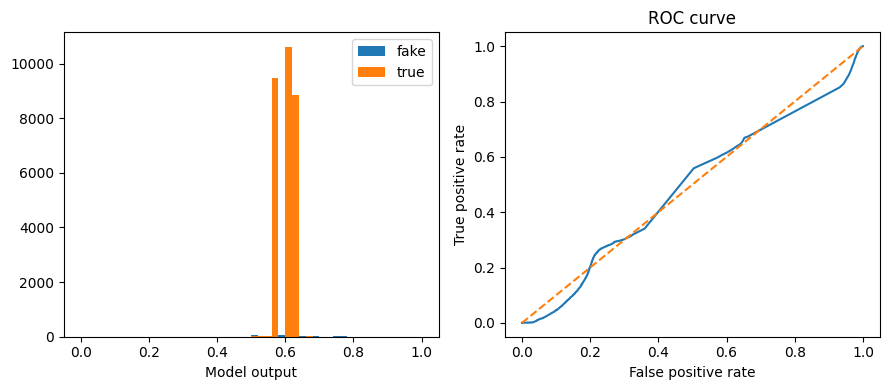

In [15]:
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

In [16]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, ax0 = plt.subplots(figsize=(9,4))
    cmap = plt.get_cmap(cmap)

    ax0.scatter(X[:,2], X[:,1], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='b', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,1], feats_i[j,1]], '-', **seg_args)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(y)
    cbar = plt.colorbar(sm, ax=ax0)
    cbar.set_label('Colorbar Label')  # Set the label for the colorbar
    
    # Adjust axes
    ax0.set_xlabel('zx_hit [mm]')
    ax0.set_ylabel('x_hit ')
    ax0.set_xlim(-100,2000)
    ax0.set_ylim(-20,20)
    plt.tight_layout()
    plt.show()

[0.39886758 0.3938537  0.5172436  0.47008666]
accuracy 0.250, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


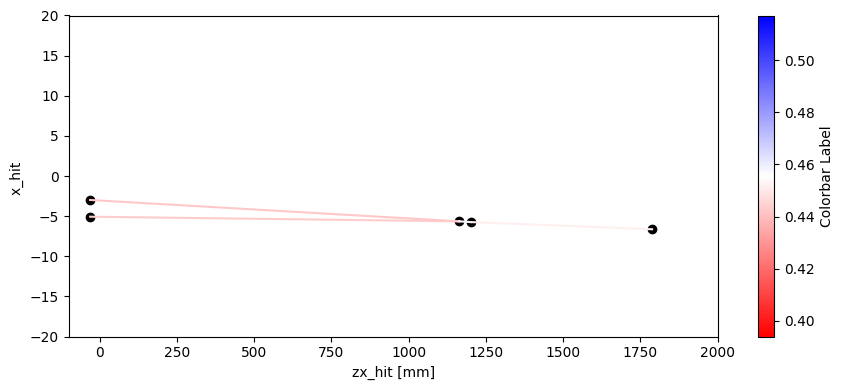

[0.39723557 0.38714403 0.52195567 0.52186525 0.4842001  0.48522896]
accuracy 0.167, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


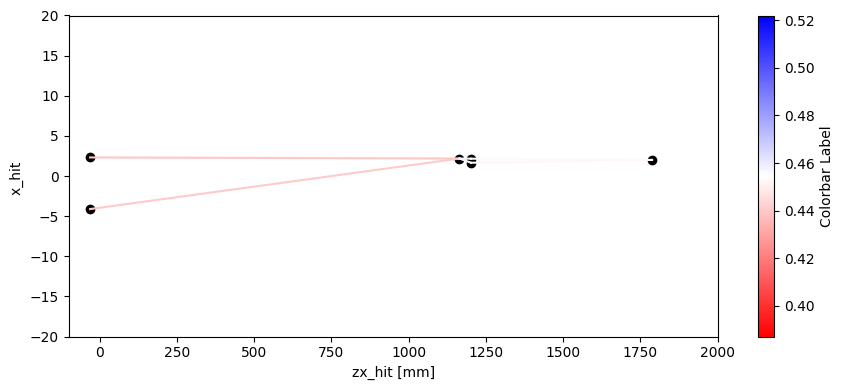

[0.40218365 0.40185142 0.3821128  0.3826757  0.48124453 0.5189206
 0.46814924 0.50183576 0.4515982  0.4563211  0.4748688  0.48571113]
accuracy 0.500, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


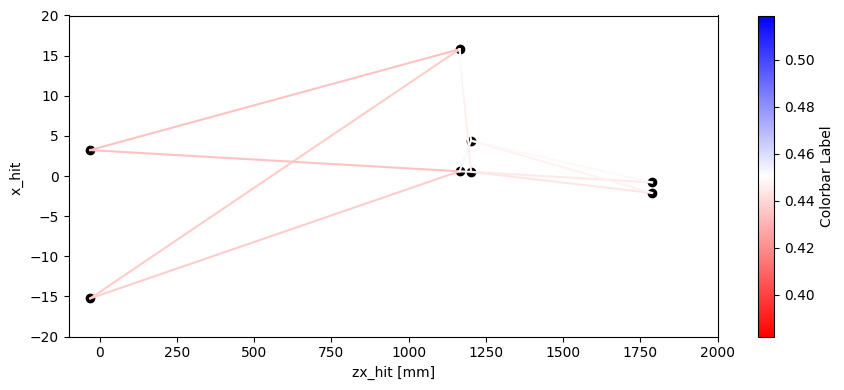

[0.39992678 0.38073763 0.52051675 0.48496833]
accuracy 0.250, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


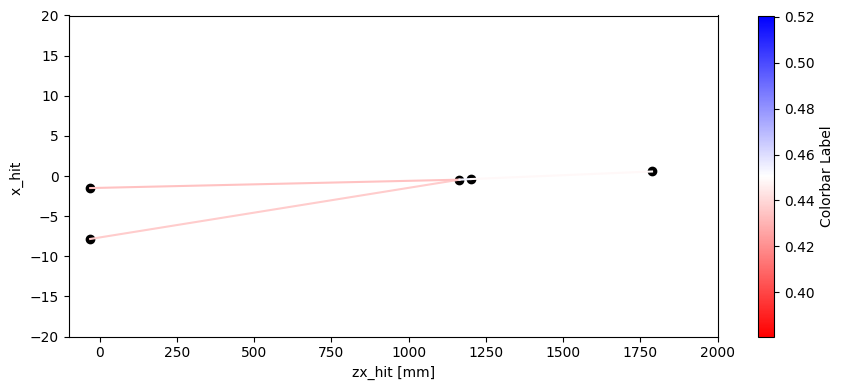

In [20]:
for i in range(4):
    g = (test_graphs[i])
    pred = test_preds[i].squeeze(0)
    print(pred)
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(g.y, pred>thresh),
        sklearn.metrics.precision_score(g.y, pred>thresh),
        sklearn.metrics.recall_score(g.y, pred>thresh)))
    draw_sample(g.X, g.Ri, g.Ro, pred, alpha_labels=False);